# 0. Imports

### Standard imports

In [1]:
import numpy as np
import pandas as pd
import tqdm as tqdm
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

### Project imports

In [2]:
from src.libs.preprocessing import DataLoader
from src.libs.visualization import DataVisualizer

# 1. Load and read the data

In [3]:
# data path
path_train_x = "data/input/denoising/train_small"
path_train_x = "data/input/denoising/train"

path_train_y = "data/input/voice_origin/train_small"
path_train_y = "data/input/voice_origin/train"

In [4]:
data_loader = DataLoader(path_x=path_train_x, path_y=path_train_y)

Import summary:
- Data imported successfully!
- Number of noised samples: 2118
- Number of original samples: 2118
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.


In [5]:
# need to normalize the data
harmonized_data = data_loader.get_harmonized_data()

# 2.Visualization

In [6]:
visualizer = DataVisualizer(harmonized_data)

## 2.a Playing some sounds

In [7]:
# chose at random an extract to read
file_number = np.random.choice(np.arange(harmonized_data.n_samples))

In [8]:
# listen to the extract without noise
visualizer.play_wav(file_number, noised=False)

In [9]:
visualizer.play_wav(file_number, noised=True)

## 2.b Displaying the time serie

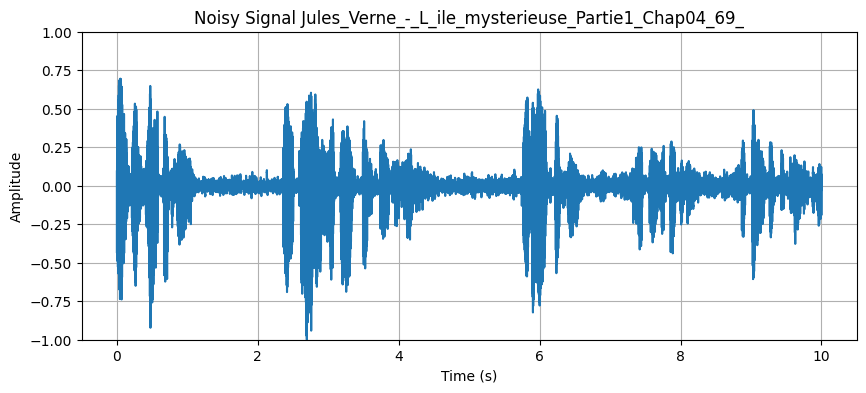

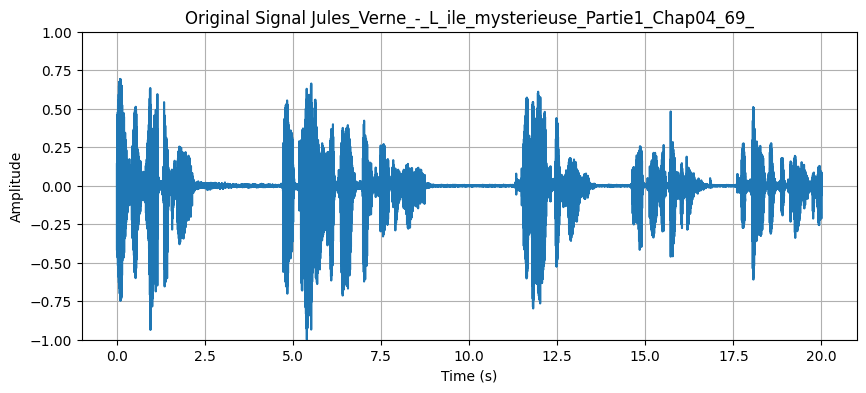

In [10]:
visualizer.display_signal(file_number, noised=True)
visualizer.display_signal(file_number, noised=False)

## 2.c Display Spectrogram

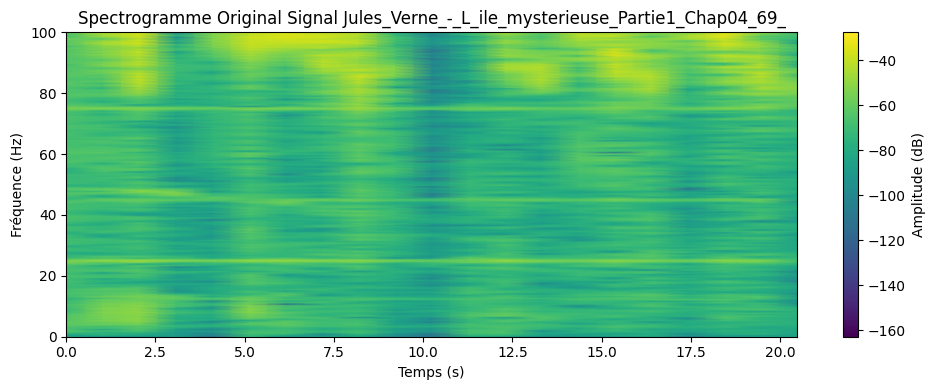

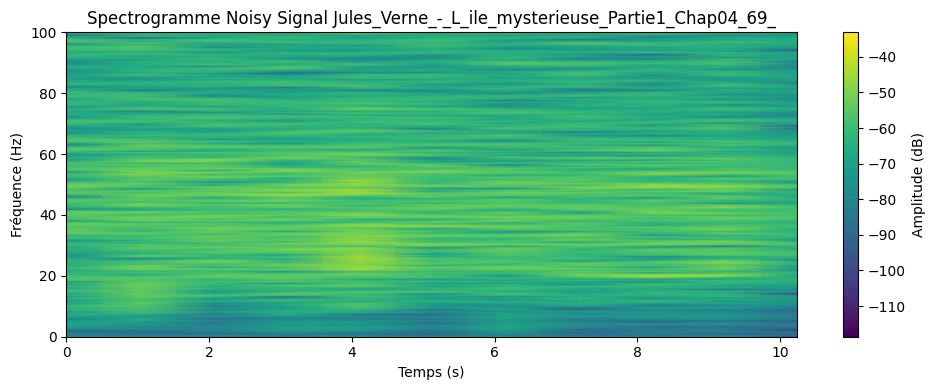

In [11]:
nperseg = 2**13
visualizer.display_spectrogram(file_number, noised=False, nperseg=nperseg)
visualizer.display_spectrogram(file_number, noised=True, nperseg=nperseg)

In [16]:
num_signals = 200
X_propre = harmonized_data.x[:num_signals]
X_bruit = harmonized_data.y[:num_signals]

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Fixer les seeds pour la reproductibilité
np.random.seed(42)
torch.manual_seed(42)

# -------------------- Données --------------------
# Simuler des signaux bruités et propres de taille 40 000
signal_length = 40000

# # Création de signaux propres et ajout de bruit
# X_propre = np.sin(np.linspace(0, 100, signal_length))  # Exemple : sinus simple
# X_propre = np.tile(X_propre, (num_signals, 1))  # 100 signaux propres
# X_bruit = X_propre + np.random.normal(0, 0.5, X_propre.shape)  # Ajouter du bruit


# Diviser les signaux en fenêtres de taille 2000
window_size = 2000


# Fonction de fenêtrage ajustée
def fenetrage(signaux, window_size):
    windows = []
    for signal in signaux:
        for i in range(
            0, len(signal) - window_size + 1, window_size
        ):  # Découpage sans chevauchement
            windows.append(signal[i : i + window_size])
    return np.array(windows)


# Appliquer la fonction
X_bruit_windows = fenetrage(X_bruit, window_size)
X_propre_windows = fenetrage(X_propre, window_size)

# Vérifier les dimensions
print(
    "Taille des fenêtres bruitées :", X_bruit_windows.shape
)  # Devrait être (total_fenêtres, window_size)
print("Taille des fenêtres propres :", X_propre_windows.shape)

# Convertir en tenseurs PyTorch
X_bruit_tensor = torch.tensor(X_bruit_windows, dtype=torch.float32).unsqueeze(
    1
)  # (N, 1, 2000)
X_propre_tensor = torch.tensor(X_propre_windows, dtype=torch.float32).unsqueeze(1)


# Convertir en tenseurs PyTorch
X_bruit_tensor = torch.tensor(X_bruit_windows, dtype=torch.float32).unsqueeze(
    1
)  # Ajouter dimension channel
X_propre_tensor = torch.tensor(X_propre_windows, dtype=torch.float32).unsqueeze(1)


class SignalDataset(Dataset):
    def __init__(self, bruit, propre):
        assert len(bruit) == len(
            propre
        ), "Les tailles des données bruitées et propres ne correspondent pas !"
        self.bruit = bruit
        self.propre = propre

    def __len__(self):
        return len(self.bruit)

    def __getitem__(self, idx):
        return self.bruit[idx], self.propre[idx]


# Initialiser Dataset et DataLoader
dataset = SignalDataset(X_bruit_tensor, X_propre_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

print(
    "Nombre total d'échantillons :", len(dataset)
)  # Doit être égal à (nombre de signaux * fenêtres)


# -------------------- Modèle Autoencodeur --------------------
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),  # (B, 16, 1000)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),  # (B, 32, 500)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),  # (B, 64, 250)
            nn.ReLU(),
        )
        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(
                64, 32, kernel_size=5, stride=2, padding=2, output_padding=1
            ),  # (B, 32, 500)
            nn.ReLU(),
            nn.ConvTranspose1d(
                32, 16, kernel_size=5, stride=2, padding=2, output_padding=1
            ),  # (B, 16, 1000)
            nn.ReLU(),
            nn.ConvTranspose1d(
                16, 1, kernel_size=5, stride=2, padding=2, output_padding=1
            ),  # (B, 1, 2000)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Initialiser le modèle
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------- Entraînement --------------------
num_epochs = 10
for epoch in range(num_epochs):
    for bruit, propre in loader:
        # Prédiction
        sortie = model(bruit)
        loss = criterion(sortie, propre)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Perte : {loss.item():.4f}")

# -------------------- Débruitage --------------------
# Exemple sur un nouveau signal
nouveau_signal_bruit = torch.tensor(X_bruit_windows[:1], dtype=torch.float32).unsqueeze(
    1
)
signal_debruite = model(nouveau_signal_bruit).detach().squeeze().numpy()

print("Signal bruité (1ère fenêtre) :", nouveau_signal_bruit.squeeze().numpy())
print("Signal débruité (1ère fenêtre) :", signal_debruite)

Taille des fenêtres bruitées : (8000, 2000)
Taille des fenêtres propres : (4000, 2000)


AssertionError: Les tailles des données bruitées et propres ne correspondent pas !

In [21]:
harmonized_data.x.shape

(2118, 40000)

In [22]:
harmonized_data.y.shape

(2118, 80000)